# Runge Kutta Nyström methods for second order equations (`Fi4N` and `MR6NN`)

You may have a second order initial value problem. The usual way to solve it with solve_ivp is to convert it to a first order problem and solve that. This way you are neglecting some of the structure of the problem. Extensisq has a few explicit general Runge Kutta Nyström (RKN) method that do take advantage of the second order structure. The 'general' means that the derivative function $\ddot{y}=f(t, y, \dot{y})$ can depend on the derivative $\dot{y}$.

Most RKN methods in the literature consider only problems where the function does not depend on $\dot{y}$, so $\ddot{y}=f(t, y)$. Methods that exploit this structure can be even more efficient. However, because this is a very specific kind of problem, extensisq contains only one such method. I will demonstrate it at the end of this notebook.

## A second order problem: damped pendulum

Lets use a damped pendulum as example. The ODE is typically written as:

$$ \ddot{\theta} + c\dot{\theta} + k \sin(\theta) = 0 $$

with angle $\theta$, angular velocity $\dot{\theta}$ and angular acceleration $\ddot{\theta}$. The damping constant is $c$, and the constant $k$ is equal to the length divided my the mass of the pendulum. The initial value problem for this ODE need an initial angle and velocity $\theta_0$ and velocity $\dot{\theta}_0$.

We can solve this with `solve_ivp`, by converting the problem to first order form. This is done by introducing the array $y = [\theta, \dot{\theta}]$. For the Nyström methods in Extensisq, it is important that all solution terms (angles or displacements) are included first, and the corresponding first derivatives (velocities) next. (That does not matter for first order methods.) The ODE function should return $\dot{y} = [\dot{\theta}, \ddot{\theta}]$. In Python code we have:

In [1]:
from math import sin

def ODEfun(t, y, c=0.1, k=1.):
    """damped pendulum"""
    th, dth = y
    return [dth,                    # passthrough of velocity
            -(k*sin(th) + c*dth)]   # the actual 2nd order ODE

y0 = [3.0, 0.]
t_span = [0, 20]  

Lets create a reference solution and a plot.

In [2]:
from scipy.integrate import solve_ivp, RK45
from extensisq import CFMR7osc, Fi4N, Me4, MR6NN
import matplotlib.pyplot as plt

ref = solve_ivp(ODEfun, t_span, y0, rtol=1e-10, atol=1e-10, method=CFMR7osc, dense_output=True)

plt.plot(ref.t, ref.y.T, label=['$u$', '$\dot{u}$'])
plt.legend(loc=2)
plt.grid()
plt.show()

ImportError: cannot import name 'Fi4N' from 'extensisq' (c:\Users\ronal\Miniconda3\lib\site-packages\extensisq\__init__.py)

The solution will eventually settle at 0, 0.

## comparing some methods

Efficiency can only be compared if accuracy is considered as well. So we make a plot that compares a few methods.

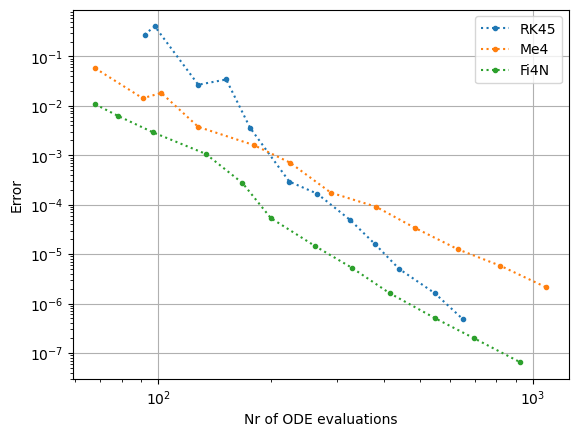

In [ ]:
import numpy as np

methods = (RK45, Me4, Fi4N)
t_eval = np.linspace(*t_span, 100)

def error(sol, ref=ref):
    """RMS error over solution interval"""
    err = sol.y - ref.sol(sol.t)
    return np.linalg.norm(err, ord=2) / (2 * sol.t.size)**0.5

for method in methods:
    n = []
    e = []
    for etol in np.linspace(1.5, 7, 12):
        tol = 10**-etol
        sol = solve_ivp(ODEfun, t_span, y0, atol=tol, rtol=tol, t_eval=t_eval,
                        method=method)
        n.append(sol.nfev)
        e.append(error(sol))
    plt.loglog(n, e, '.:', label=method.__name__)
plt.grid()
plt.legend()
plt.xlabel('Nr of ODE evaluations')
plt.ylabel('Error')
plt.show()
    

The plot compares the general RKN method `Fi4N` ([Fine, 4th order](https://doi.org/10.1007/BF02278707)) to two regular RK methods `Me4` (Merson, 4th order) and `RK45` (Dormand Prince, 5th order). The method of Fine is more efficient at almost all tested tolerances, but the higher order method `RK45` is catching up.

Notice that `t_eval` was used in the code. This implies that the solution is interpolated. Using the knowledge that we are solving a second order ODE makes it possible to create a C2 continuous quintic hermite interpolant from just the end points of each step. This is what `Fi4N` does. For regular RK methods, this can only be a C1 continous cubic hermite interpolant, which is sufficient for low order methods only. Most methods RK methods, including `RK45` and `Me4`, use an interpolant that is specifically contructed for it. This can also be done for higher order RKN methods, but it is not necessary for order 4 (or even 5) and below.

I really like the 4th order method of Fine. Comments in the book of Hairer did made me think that there isn't much to gain from general RK Nyström methods, but `Fi4N` changed my mind and seduced me to add a few Nyström methods to Extensisq. 

## Stability of `Fi4N`

I am using the stability theory from [Lunk](https://doi.org/10.1016/j.apnum.2004.09.003), but instead of his plot, I'm using the regular ones. Just keep in mind that this is the stability region for *a pair* of complex poles, as opposed to for a single complex pole in regular RK method stability plots. I've seen papers with distinct stability domains for the velocity and displacement component, but Lunk does not make this distinction. The stability plot of `Fi4N` now looks like this: 

![Stability region](stability%20regions/stabilityFi4N.png)

It  looks weird, compared to regular RK methods. This is the case for most RKN methods. The domain looks roughly rectangular, compared quarter circles for regular RK methods. I have modified the stiffness detection method for RKN methods to account for this.

The stability plot of `Fi4N` shows that the method works best for oscillatory problems with low damping (like our pendulum problem). It can be inefficient for problems with a dominant real pole, or high damping. (Change c=0.1 in ODEfun to c=2 in the first code block, run all cells again, and see what happens.)

The stability plot indicates no stability on hte imaginary axis. However, the method `Fi4N` seems to handle undamped mechanics well in practice. The next section shows an example of this.

## Velocity independent second order ODEs

The ODE of the damped pendulum becomes independent of velocity if the damping constant c=0. For this special case, there are more efficient second order methods. (This is what the comment in Hairers book mentioned above was about.) The special structure of the equations (second order with no derivative dependence) makes it possible to create high order methods, with few stages per step compared to a regular RK or RKN method.

Extensisq only has one such method, because this kind of problem is very specific. It is 6th order RKN, with 4th order embedded method by [EL-Mikkawy and Rahmo](https://doi.org/10.1016/S0096-3003(02)00436-8), which I implemented as `MR6NN`. The double 'N' is to indicate that it is a pure Nyström method (no velocity dependence). This method uses 6 stages per step, which is one more than the minimum for 6th order in such RKN methods. The extra stage is used to make 9 out of 10 7th order error terms vanish. The remaining error term is tiny, making `MR6NN` almost 7th order. For comparison, regular RK and general RKN methods need 7 stages per step to reach order 6.

Let's try it out. First we need a reference solution without damping.

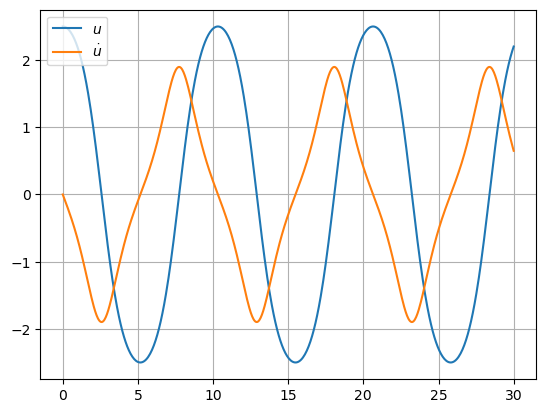

In [ ]:
def ODEfun_noV(t, y):
    return ODEfun(t, y, c=0.)

t_span_noV = [0, 30]
y0_nov = [2.5, 0]
ref_noV = solve_ivp(ODEfun_noV, t_span_noV, y0_nov, rtol=1e-12, atol=1e-12, method=CFMR7osc, dense_output=True)

plt.plot(ref_noV.t, ref_noV.y.T, label=['$u$', '$\dot{u}$'])
plt.legend(loc=2)
plt.grid()
plt.show()

The response indeed shows no damping. The solution becomes periodic. Now we can make the efficiency plot for the undamped problem and compare `MR6NN` to a few other methods.

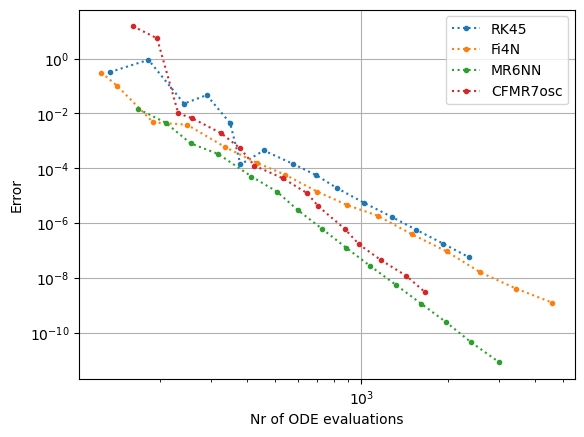

In [ ]:
methods_noV = (RK45, Fi4N, MR6NN, CFMR7osc)
t_eval_noV = np.linspace(*t_span_noV, 100)

for method in methods_noV:
    n = []
    e = []
    for etol in np.linspace(2, 9, 15):
        tol = 10**-etol
        sol = solve_ivp(ODEfun_noV, t_span_noV, y0_nov, atol=tol, rtol=tol,
                        t_eval=t_eval_noV, method=method)
        n.append(sol.nfev)
        e.append(error(sol, ref=ref_noV))
    plt.loglog(n, e, '.:', label=method.__name__)
plt.grid()
plt.legend()
plt.xlabel('Nr of ODE evaluations')
plt.ylabel('Error')
plt.show()

The pure Nyström method `DPM6NN` is efficient. It takes a very low tolerance for the 7th order `CFMR7osc` to catch up. (And `CFMR7osc` often beats `DOP853`).

Also notice how well `Fi4N` compares to the higher order `RK45`. (The method `RK45` seems to perform poorly on undamped problems.)

Extensisq tries to detect if the problem is velocity dependent. An assertion error is raised if the method detects velocity dependence, which `MR6NN` does not support.

In [ ]:
try:
    sol = solve_ivp(ODEfun, t_span, y0, method=MR6NN)
except Exception as err:
    print(err)

This method is for velocity independent ODEs, but `fun` seems velocity dependent.


## Other Nyström methods

Beside `Fi4N` and `MR6NN`, Extensisq contains 2 other Nyström methods. These are the fifth order method by Fine `Fi5N` from the same [paper](https://doi.org/10.1007/BF02278707), and a special fifth order method by [Murua](https://doi.org/10.1016/S0168-9274(98)00055-5). The idea of the later method is to have several pairs of stages in which the function is evaluated twice, with different velocities but identical time and position. This can be beneficial for the simulation of multibody systems in which the calculations required for each position can be relatively costly. The method RK5495, implemented as `Mu5Nmb` has 9 stages, 8 of which belong to a pair. Therefore, there are only 5 unique time/position combinations. This method will only be efficient if the other 4 stages can be evaluated at relatively low cost. For normal second order problems, the methods of Fine are probably more useful.